# Dynamic power and quantization

_23 July 2021_ <br />
_Chuan-Zheng Lee <czlee@stanford.edu>_ <br />
_Rough working_

These are the first plots after I implemented dynamic quantization range for the digital scheme, which shouldn't affect dynamic power scheme, but this did involve some refactoring of the dynamic power code to reuse the exponential moving average framework for dynamic quantization in the digital scheme.

Note: These plots increased the dataset size to 20000, since we're only going up to 20 clients.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt

from plots_utils import plot_averaged_training_charts, plot_evaluation_vs_clients

# Dynamic power

On commit `8c7cffd`.

In [2]:
results_dir = Path("../results-downloaded/20210722-dynpower-2/")

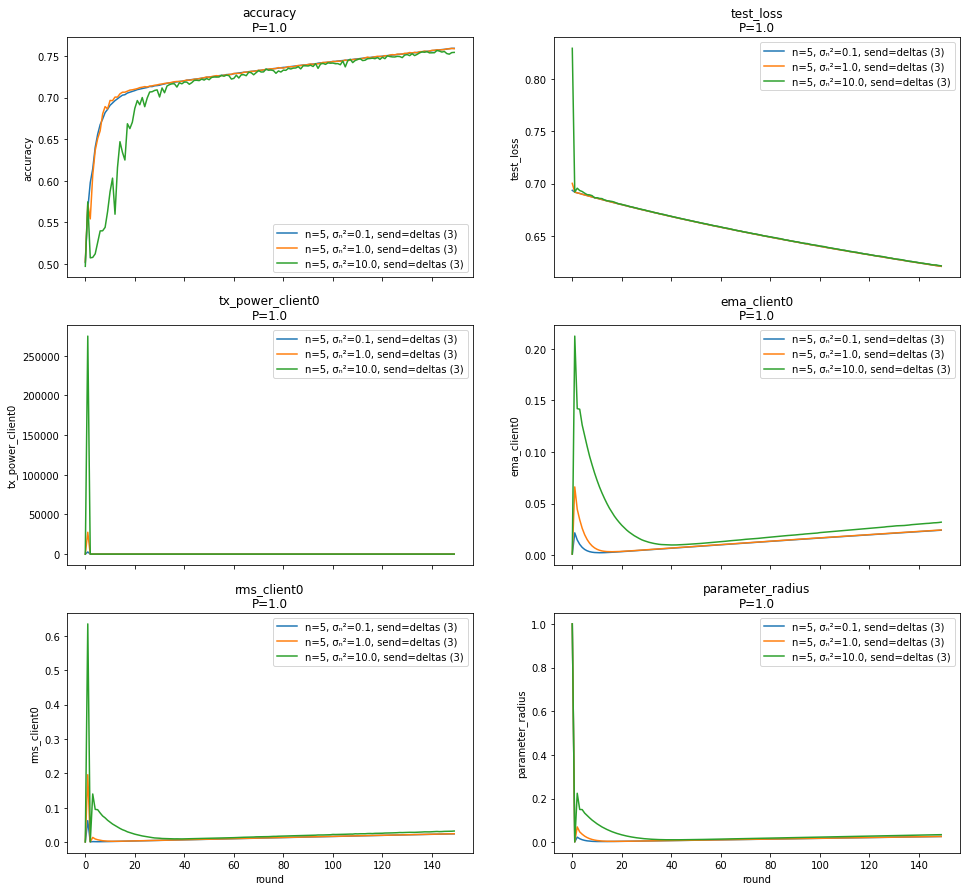

In [3]:
fixed_specs = {
    'rounds': 150,
    'batch_size': 64,
    'lr_client': 0.01,
    'epochs': 1,
    'small': False,
    'ema_coefficient': 1 / 3,
    'power_update_period': 1,
    'power_quantile': 0.9,
    'power_factor': 0.9,
    'data_per_client': 20000,
}
title_specs = {
    'power': 1.0,
}
series_specs = {
    'clients': [5],
    'noise': [0.1, 1.0, 10.0],  # 100 is a disaster and obscures most of these plots for this setting
    'send': ['deltas'],
}
fields = ['accuracy', 'test_loss', 'tx_power_client0', 'ema_client0', 'rms_client0', 'parameter_radius']

plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs);

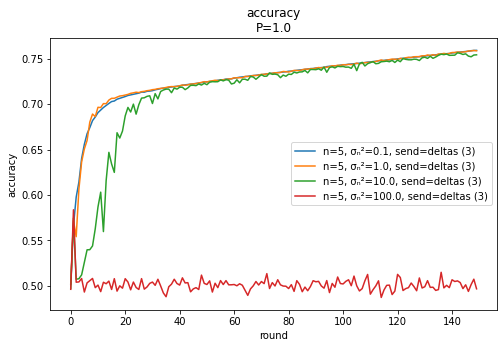

In [4]:
series_specs['noise'] = '__all__'
plot_averaged_training_charts(results_dir, ['accuracy'], title_specs, fixed_specs, series_specs);

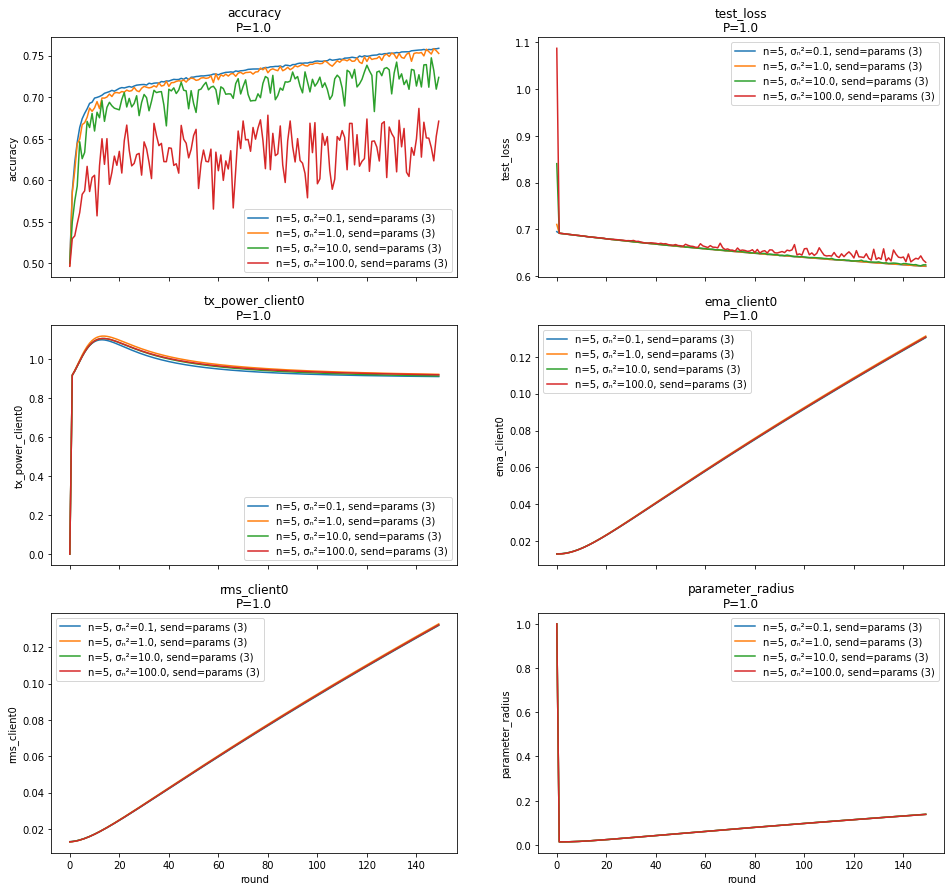

In [5]:
series_specs['send'] = ['params']
plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs);

# Dynamic range

First, the "real" ones, using the `read-zero` option:

In [6]:
results_dir = Path("../results-downloaded/20210722-dynquant/")

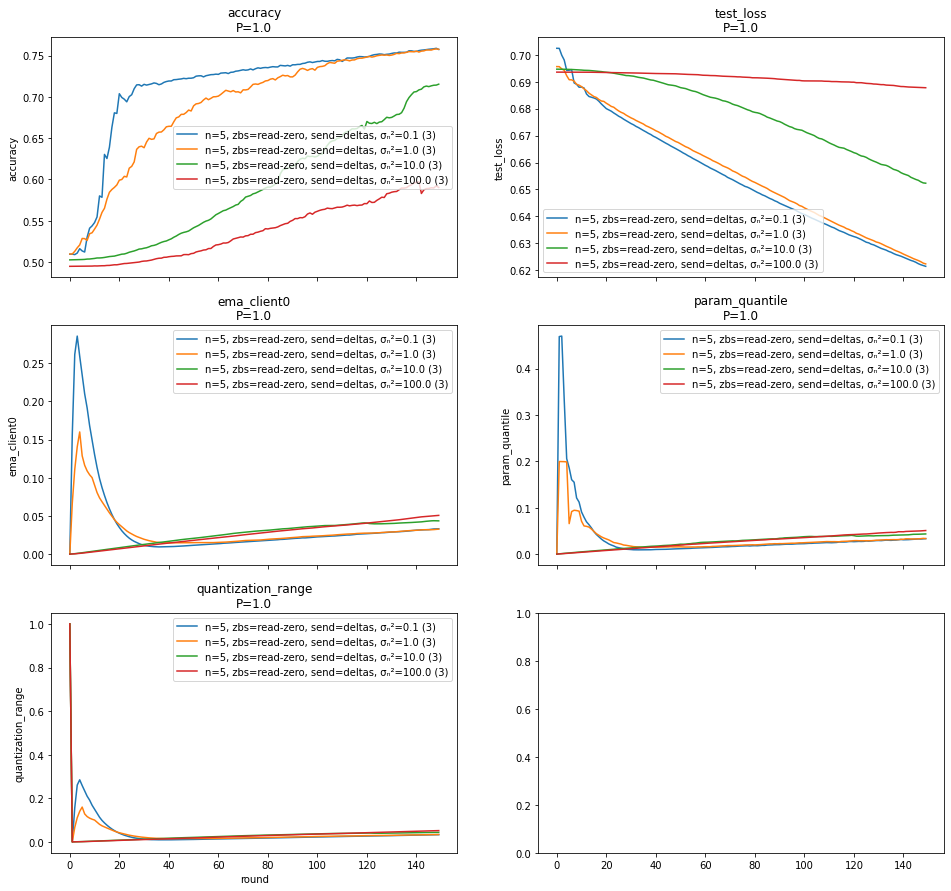

In [7]:
fixed_specs = {
    'rounds': 150,
    'batch_size': 64,
    'lr_client': 0.01,
    'epochs': 1,
    'small': False,
    'ema_coefficient': 1 / 3,
    'qrange_update_period': 1,
    'qrange_param_quantile': 0.9,
    'qrange_client_quantile': 0.9,
    'data_per_client': 20000,
    'channel_uses': None,
}
title_specs = {
    'power': 1.0,
        
}
series_specs = {
    'clients': [5],
    'zero_bits_strategy': ['read-zero'],
    'send': ['deltas'],
    'noise': '__all__',
}
fields = ['accuracy', 'test_loss', 'ema_client0', 'param_quantile', 'quantization_range']

plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs);

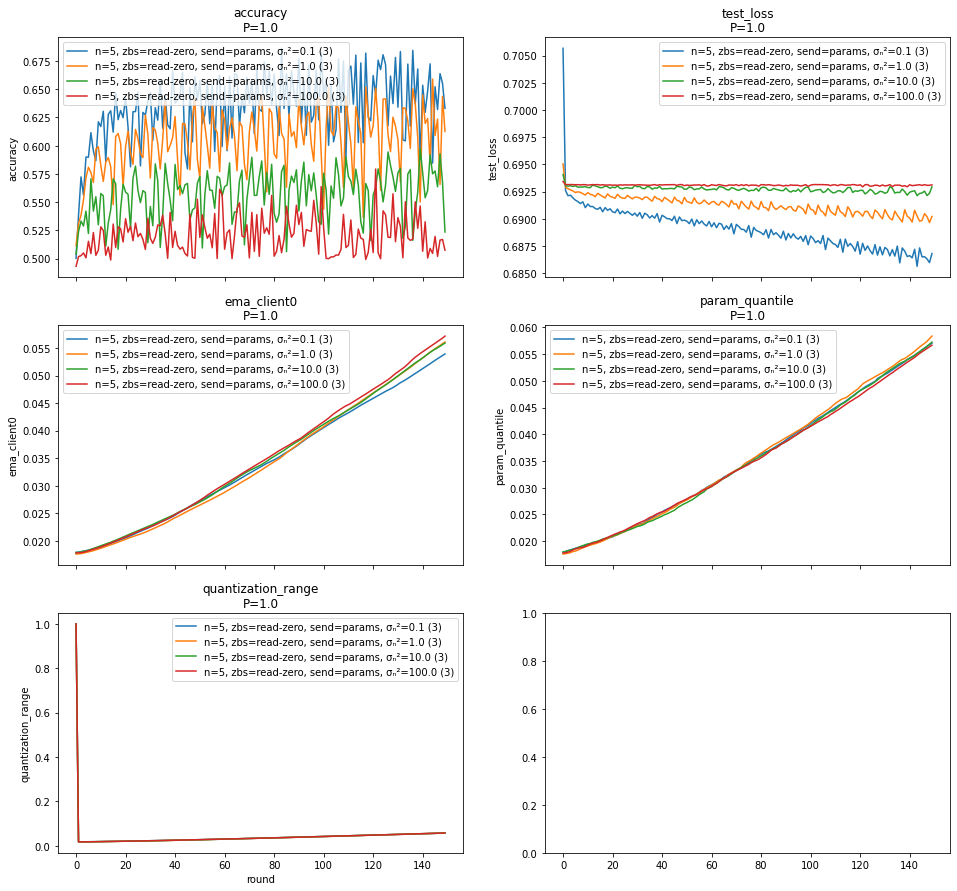

In [8]:
series_specs['send'] = ['params']
plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs);

The `min-one` ones perform surprisingly well, but they also (by design) give the digital scheme an unrealistic advantage.

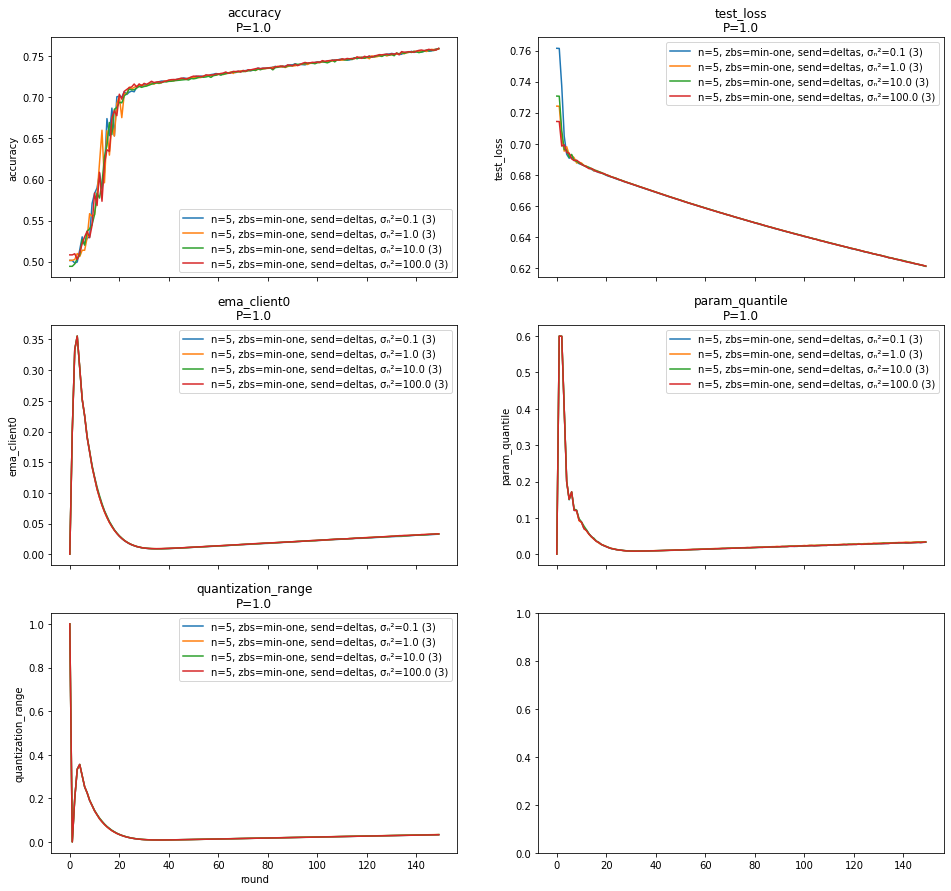

In [9]:
series_specs['zero_bits_strategy'] = ['min-one']
series_specs['send'] = ['deltas']
plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs);

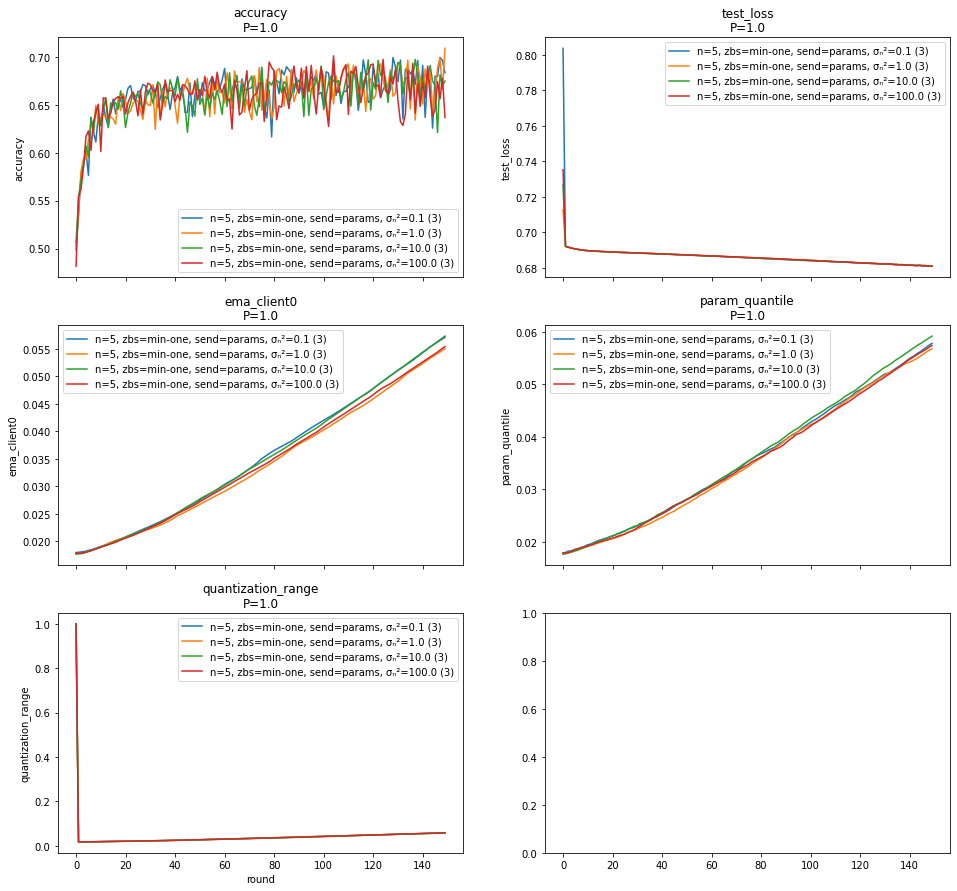

In [10]:
series_specs['send'] = ['params']
plot_averaged_training_charts(results_dir, fields, title_specs, fixed_specs, series_specs);

How many bits do we have in each of these settings?

In [11]:
# check in files

from numpy import log2
import pandas as pd
from plots_utils import all_subsubdirectories, get_args, get_eval

seen = []
reports = pd.DataFrame()
s = 2001  # number of channel uses

for directory in all_subsubdirectories(results_dir):
    args = get_args(directory)
    
    P = args['power']
    σₙ2 = args['noise']
    n = args['clients']
    if (P, σₙ2, n) in seen:
        continue
        
    index = directory.name
    reports.loc[index, 'P'] = P
    reports.loc[index, 'σₙ²'] = σₙ2
    reports.loc[index, 'n'] = n

    try:
        evaluation = get_eval(directory)
    except FileNotFoundError:
        continue

    reports.loc[index, 'bpcu eval'] = evaluation['bits_per_channel_use']
    reports.loc[index, 'bpr eval'] = evaluation['bits_per_round']

    seen.append((P, σₙ2, n))

reports['bpcu calc'] = log2(1 + reports['n'] * reports['P'] / reports['σₙ²']) / (2 * reports['n'])
reports['bpr calc'] = reports['bpcu calc'] * s
reports['bpcu diff'] = abs(reports['bpcu calc'] - reports['bpcu eval'])
reports['bpr diff'] = abs(reports['bpr calc'] - reports['bpr eval'])

reports.sort_index()

,P,σₙ²,n,bpcu eval,bpr eval,bpcu calc,bpr calc,bpcu diff,bpr diff
clients-20-noise-0.1-iteration-0,1.0,0.1,20.0,0.191276,382.743861,0.191276,382.743861,2.775558e-17,5.684342e-14
clients-20-noise-1.0-iteration-1,1.0,1.0,20.0,0.109808,219.725679,0.109808,219.725679,0.000000e+00,0.000000e+00
clients-20-noise-10.0-iteration-0,1.0,10.0,20.0,0.039624,79.287749,0.039624,79.287749,0.000000e+00,0.000000e+00
clients-20-noise-100.0-iteration-1,1.0,100.0,20.0,0.006576,13.158296,0.006576,13.158296,0.000000e+00,0.000000e+00
clients-5-noise-0.1-iteration-1,1.0,0.1,5.0,0.567243,1135.052311,0.567243,1135.052311,0.000000e+00,0.000000e+00
clients-5-noise-1.0-iteration-1,1.0,1.0,5.0,0.258496,517.250996,0.258496,517.250996,0.000000e+00,0.000000e+00
clients-5-noise-10.0-iteration-2,1.0,10.0,5.0,0.058496,117.050996,0.058496,117.050996,0.000000e+00,0.000000e+00
clients-5-noise-100.0-iteration-2,1.0,100.0,5.0,0.007039,14.084905,0.007039,14.084905,1.734723e-18,3.552714e-15
